# **AML Homework-3**

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from PIL import Image
import cv2
import tensorflow as tf

# 1.Apply PCA to the images from folder '360 Rocks'.

In [90]:
import os
import zipfile
import pandas as pd
from PIL import Image
import numpy as np

# Path to the zip file in Colab
zip_path = '/content/360 Rocks.zip'

# Extract the contents of the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/images')

# Function to resize images to 64x64, convert them to grayscale arrays, and create a DataFrame
def create_dataset(folder_path):
    data = []
    labels = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        if img_path.endswith(".jpg"):  # Assuming images are in JPG format
            img = Image.open(img_path)
            img = img.resize((100, 100))  # Resize image to 64x64
            img = img.convert('L')  # Convert image to grayscale
            img_array = np.array(img)
            data.append(img_array)
            label = filename[0]  # Extract the first character of the filename as the label
            if label == 'I':
                labels.append(0)
            elif label == 'S':
                labels.append(1)
            elif label == 'M':
                labels.append(2)

    return np.array(data), np.array(labels)

# Path to the folder containing extracted images
image_folder_path = '/content/images/360 Rocks'

# Create the dataset
data, labels = create_dataset(image_folder_path)

# Create a DataFrame
df = pd.DataFrame(data.reshape((data.shape[0], -1)))  # Reshape data to a 1D array for each image
df['Label'] = labels

# Save the DataFrame to a CSV file
csv_path = '/content/360_dataset_resized_labelled.csv'
df.to_csv(csv_path, index=False)

# Display the first few rows of the DataFrame
df.head()


,0,1,2,3,4,5,6,7,8,9,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,Label
0,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,2
1,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,0
2,255,255,255,255,255,255,255,255,255,255,...,167,198,184,202,253,255,255,255,255,2
3,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,1
4,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,2


In [91]:
X_train=df.iloc[:,:-1].values
y_train=pd.DataFrame(df.iloc[:,-1])

In [92]:
X_train.shape

(360, 10000)

In [93]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)                     # preserving 95% of varience
X_reduced = pca.fit_transform(X_train)           # fit the PCA model to Training set
X_recovered = pca.inverse_transform(X_reduced)   # Recovered data after applying pca on Training set

#*How many components do you need to preserve 95% of the variance?*

In [94]:
print(X_reduced.shape[1])

182


#*2.Plot 10 images of your choice in the original form (without PCA) and then plot their reconstruction (projection in the original space) after you kept 95% of variance using PCA.*

In [95]:
# https://github.com/ageron/handson-ml2/blob/master/08_dimensionality_reduction.ipynb
def plot_digits(instances):
    size = 100
    images_per_row = 5
    n_rows = 2
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,images_per_row * size)
    plt.imshow(big_image, cmap = mpl.cm.binary)
    plt.axis("off")

Text(0.5, 1.0, 'reconstruction')

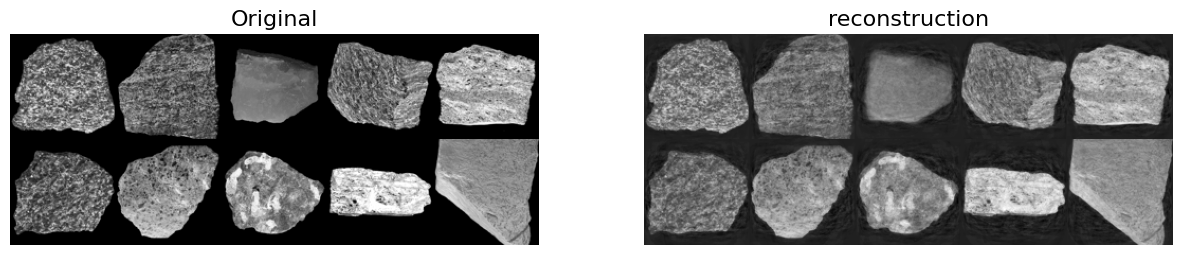

In [96]:
plt.figure(figsize=(15, 10))
plt.subplot(121)
plot_digits(X_train[1:11])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[1:11])
plt.title("reconstruction", fontsize=16)

#3.Each of the images belongs to one of three rock categories. The category is indicated by the first letter in the filename (I, M and S). We will now try to see if the visualization can help us identify different clusters.

A. Use PCA to reduce dimensionality to only 2 dimensions. How much of the variance is explained with the first two principal components?

In [97]:
sum(pca.explained_variance_ratio_[:2])

0.36654616363632164

*Use PCA to reduce dimensionality to only 2 dimensions*

In [98]:
pca_2D = PCA(n_components=2) # n_components=2 reduces the number of features to 2
X_2D_PCA = pd.DataFrame(pca_2D.fit_transform(X_train),columns=['x','y'])

*Use LLE to reduce dimensionality to only 2 dimensions*

In [99]:
from sklearn.manifold import LocallyLinearEmbedding
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)
X_2D_LLE = pd.DataFrame(lle.fit_transform(X_train),columns=['x','y'])

*Use TSNE to reduce dimensionality to only 2 dimensions*

In [100]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(X_train)
X_2D_TSNE = pd.DataFrame(X_embedded,columns=['x','y'])

Use MDS to reduce dimensionality to only 2 dimensions

In [101]:
from sklearn.manifold import MDS
embedding = MDS(n_components=2,n_jobs=-1,max_iter=100).fit_transform(X_train[:5000])
X_2D_MDS = pd.DataFrame(embedding,columns=['x','y'])

*Plot 1000 random images from the training
set in the 2D space spanned by the first two principal components. Use a scatterplot with 10 different
colors to represent each image’s target class*

In [102]:
def plot_scatter(reduced_data,name):
  image_labels=y_train.values.tolist()
  label_type = np.unique(image_labels)
  label_colors = {0: 'red', 2: 'green', 1: 'blue'}
  plt.figure(figsize=(13, 10))
  for lab in label_type:
      if lab== 0:
        lab_label='I'
      elif lab==1:
        lab_label='S'
      else:
        lab_label='M'
      indices = np.where(image_labels == lab)
      plt.scatter(
          reduced_data[indices, 0],
          reduced_data[indices, 1],

          label=lab_label,
          color=label_colors[lab],
      )
      plt.axis("off")
      for i in indices[0]:
        if i % 3 == 0 :
                        image_path = os.path.join(image_folder_path, os.listdir(image_folder_path)[i])
                        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (28, 28))
                        imagebox = OffsetImage(img, zoom=0.7,cmap='gray')
                        xy = reduced_data[i]
                        ab = AnnotationBbox(imagebox, xy, xycoords='data', boxcoords="data", frameon=False, arrowprops=dict(arrowstyle="->"))
                        plt.gca().add_artist(ab)
  plt.title(f'{name} Scatter Plot of Reduced Data with Images')
  plt.legend()
  plt.show()


B. Plot a 2D scatter plot of the images spanned by the first two principal components

- *PCA PLOT*

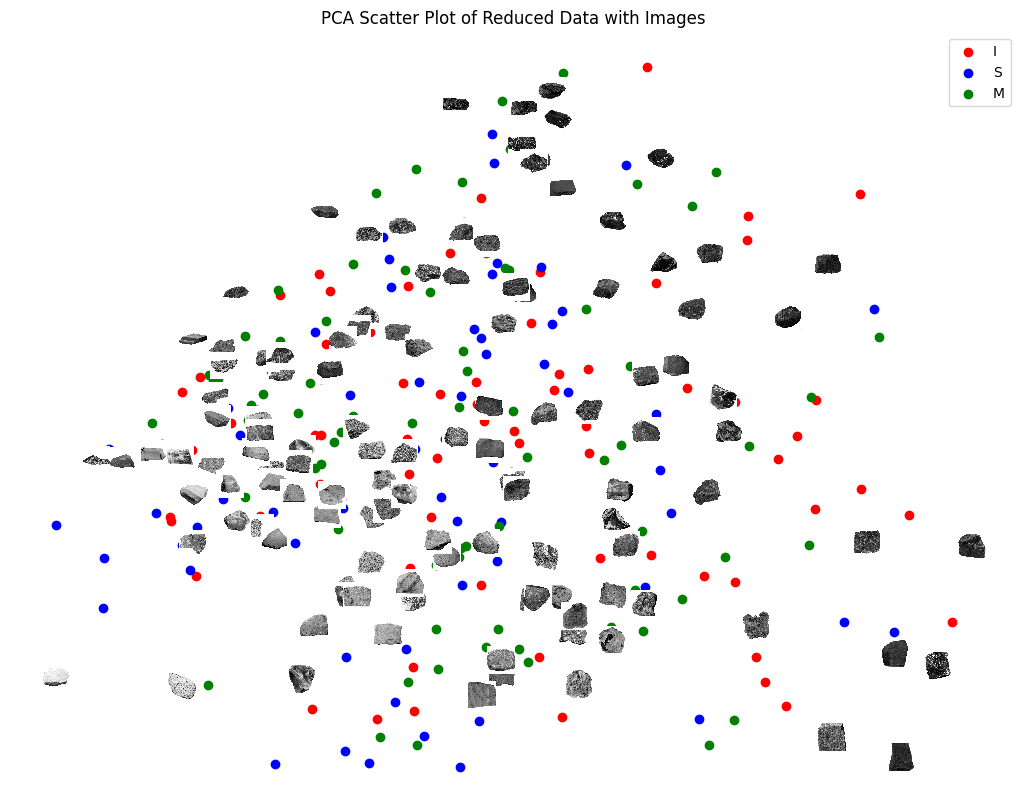

In [103]:
plot_scatter(pca_2D.fit_transform(X_train),'PCA')

- *LLE PLOT*

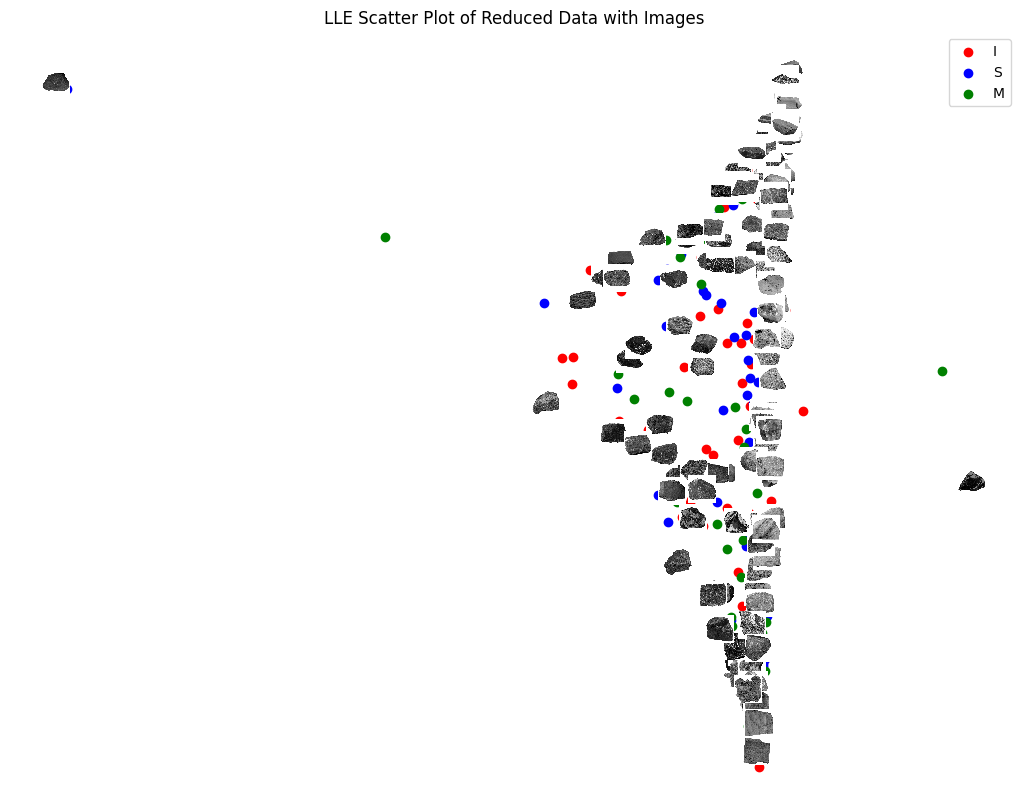

In [104]:
plot_scatter(lle.fit_transform(X_train),'LLE')

- *TSNE PLOT*

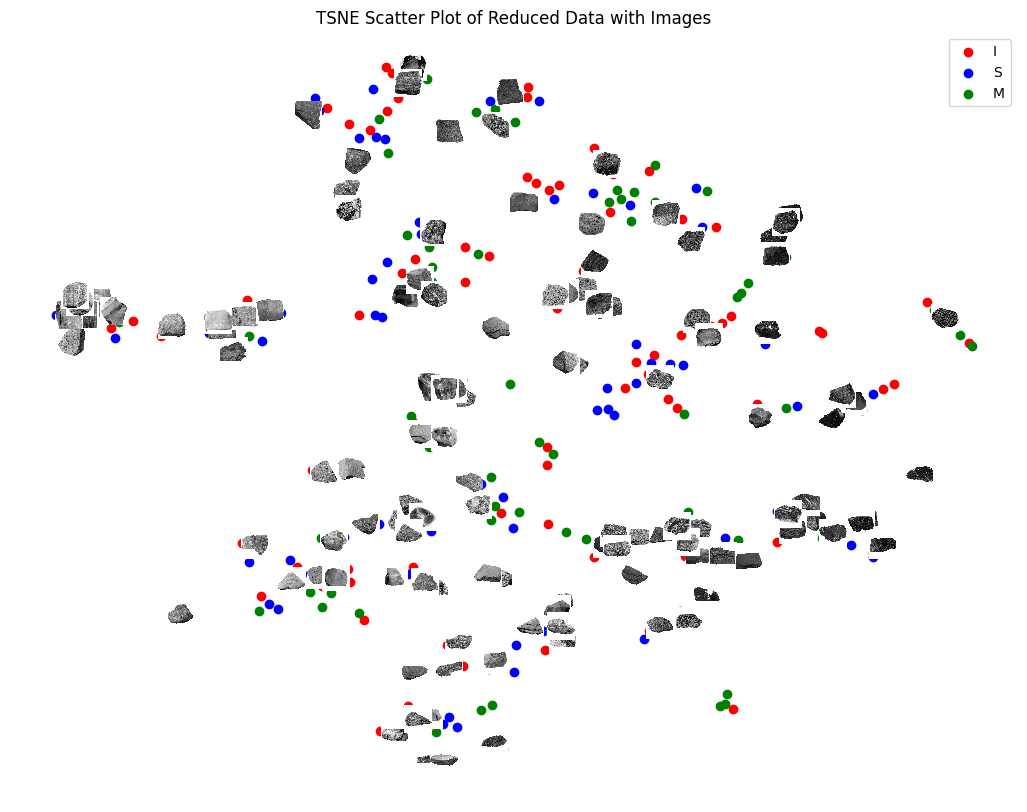

In [ ]:
plot_scatter(X_embedded,'TSNE')

- *MDS PLOT*

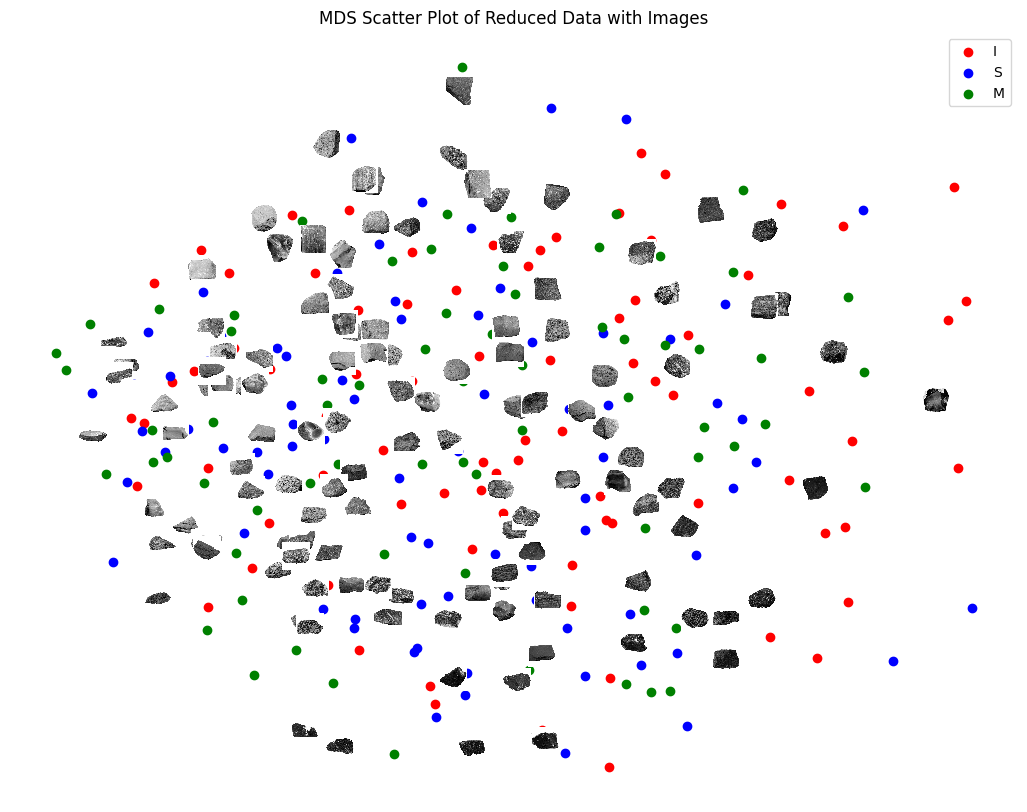

In [ ]:
plot_scatter(embedding,'MDS')

C.Which of the visualizations do you prefer and why?

We prefer LLE vusualization Since it appears to be effectively separated across different classes

# 4. Now let's see if these dimensionality reduction techniques can give us similar features to those that humans use to judge the images.

In [105]:
features = np.loadtxt('/content/mds_360.txt')

In [106]:
results = {}
corr = []
from scipy.spatial import procrustes
from scipy.stats import pearsonr
dimRed = {
    'PCA': PCA(n_components=8),
    't-SNE': TSNE(n_components=8, method='exact'),
    'LLE': LocallyLinearEmbedding(n_components=8),
    'MDS': MDS(n_components=8),
}

for name, method in dimRed.items():
  reducedImage = method.fit_transform(X_train)
  m1, m2, disparity = procrustes(features, reducedImage)
  corr = [pearsonr(m1[:, i], m2[:, i])[0] for i in range(8)]

  results[method] = {
        'Disparity': disparity,
        'Correlations': corr,
    }



In [107]:
from prettytable import PrettyTable

disp_table = PrettyTable()
disp_table.field_names = ["Method", "Disparity", "Correlations"]

# Add rows to the table
for method_name, result in results.items():
    disparity_value = result['Disparity']
    correlations = result['Correlations']

    disp_table.add_row([method_name, f"{disparity_value:.4f}", correlations])

# Print the formatted table
print(disp_table)

+----------------------------------------+-----------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                 Method                 | Disparity |                                                                               Correlations                                                                               |
+----------------------------------------+-----------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|          PCA(n_components=8)           |   0.9882  | [0.07625793012975741, 0.11938062369796651, 0.13886405158760975, 0.13937648187939586, 0.10968967674527268, 0.12216605922783019, 0.07042462569250948, 0.0774041358313436]  |
|  TSNE(method='exact', n_components=8)  |   0.9888  |  [0.13447129364160285, 0.1032660316020077

#5.Cluster the 360 images using K-Means.

In [ ]:
X_10k=X_2D_PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X_10k) for k in range(1, 10)]
silhouette_scores = [silhouette_score(X_10k, model.labels_)
                     for model in kmeans_per_k[1:]]

A.To speed up the algorithm, use PCA to reduce the dimensionality of the dataset to two. Determine the number of clusters using one of the techniques we discussed in class.

Text(0, 0.5, 'Silhouette score')

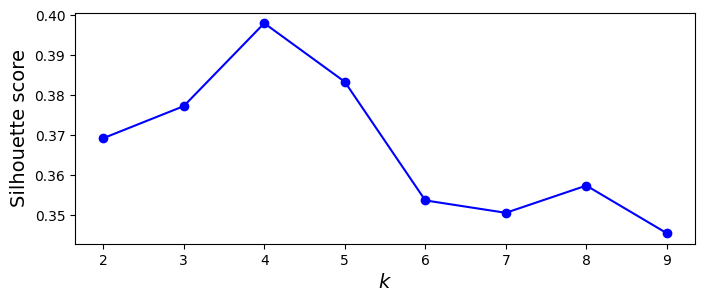

In [ ]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10),silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)

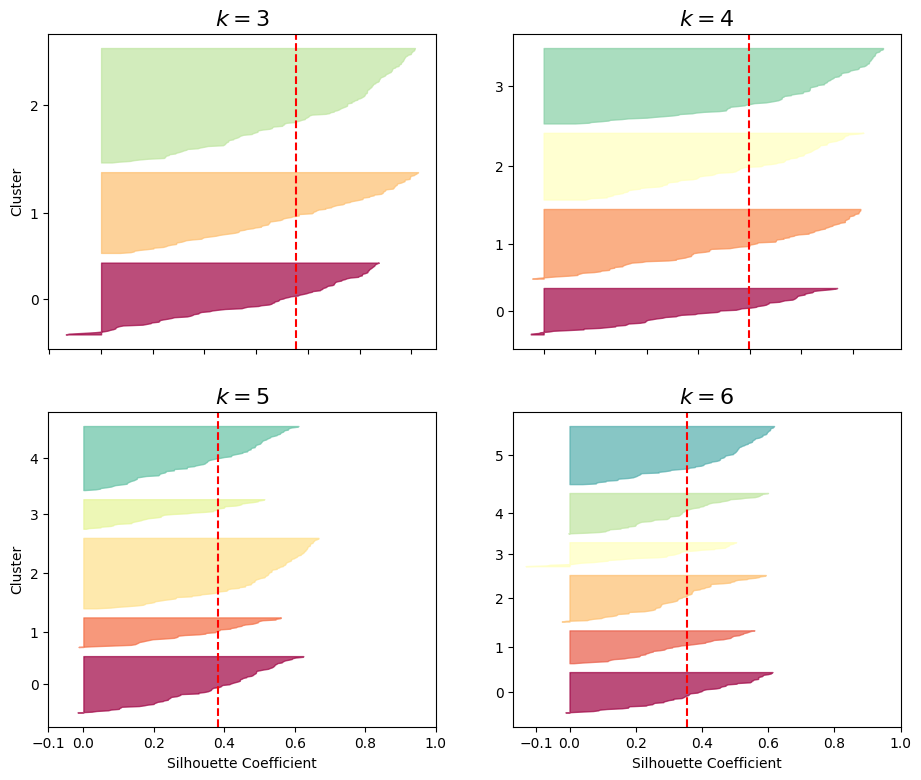

In [ ]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
plt.figure(figsize=(11, 9))
for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X_10k, y_pred)
    padding = len(X_10k) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()
        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")

    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

we select k=4 as
- most instances extend beyond the dashed line to the right and closer to 1.0
- most of the clusters are of similar size

B. Visualize the clusters

In [ ]:
def plot_data(X):
    plt.plot(X.iloc[:, 0], X.iloc[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

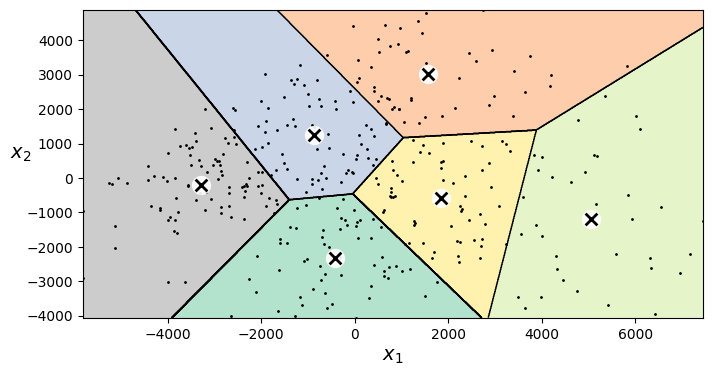

In [ ]:
X=pd.DataFrame(X_10k)
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_per_k[5],X)
plt.show()

In [ ]:
ypred=kmeans_per_k[5].predict(X_10k)
x2=pd.DataFrame(X_10k)
x1=pd.DataFrame(ypred,columns=['cluster'])
X_10k_clus=pd.concat([x2,x1],axis=1)

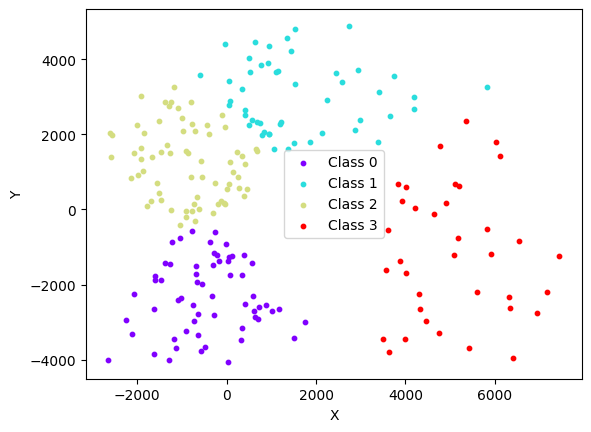

In [ ]:
num_classes=4
colors = plt.cm.rainbow(np.linspace(0, 1, num_classes))
fig, ax = plt.subplots()
for i in range(num_classes):
    mask = x1['cluster'] == i
    ax.scatter(X_10k_clus.loc[mask,'x'],X_10k_clus.loc[mask,'y'],s=10, c=colors[i], label=f'Class {i}')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()
plt.show()

In [ ]:
def plot_cluster_imgs(c):
    class_zero=X_10k_clus[X_10k_clus['cluster']==c]
    X_10k_recovered=pca_2D.inverse_transform(class_zero.iloc[:,:-1])
    random_rows_knn = [0,1,2,3,4,5,6,7,8]
    f, axarr = plt.subplots(3,3)
    axarr[0,0].imshow(X_10k_recovered[random_rows_knn[0]].reshape((100,100)))
    axarr[0,1].imshow(X_10k_recovered[random_rows_knn[1]].reshape((100,100)))
    axarr[0,2].imshow(X_10k_recovered[random_rows_knn[2]].reshape((100,100)))
    axarr[1,0].imshow(X_10k_recovered[random_rows_knn[3]].reshape((100,100)))
    axarr[1,1].imshow(X_10k_recovered[random_rows_knn[4]].reshape((100,100)))
    axarr[1,2].imshow(X_10k_recovered[random_rows_knn[5]].reshape((100,100)))
    axarr[2,0].imshow(X_10k_recovered[random_rows_knn[6]].reshape((100,100)))
    axarr[2,1].imshow(X_10k_recovered[random_rows_knn[7]].reshape((100,100)))
    axarr[2,2].imshow(X_10k_recovered[random_rows_knn[8]].reshape((100,100)))

In [ ]:
def plot_cluster_imgs_originals(c):
    k=X_train[:10000]
    data_ori=pd.DataFrame(k[X_10k_clus['cluster']==c])
    f, axarr = plt.subplots(3,3)
    axarr[0,0].imshow(np.asarray(list(data_ori.iloc[0,:])).reshape((100,100)))
    axarr[0,1].imshow(np.asarray(list(data_ori.iloc[1,:])).reshape((100,100)))
    axarr[0,2].imshow(np.asarray(list(data_ori.iloc[2,:])).reshape((100,100)))
    axarr[1,0].imshow(np.asarray(list(data_ori.iloc[3,:])).reshape((100,100)))
    axarr[1,1].imshow(np.asarray(list(data_ori.iloc[4,:])).reshape((100,100)))
    axarr[1,2].imshow(np.asarray(list(data_ori.iloc[5,:])).reshape((100,100)))
    axarr[2,0].imshow(np.asarray(list(data_ori.iloc[6,:])).reshape((100,100)))
    axarr[2,1].imshow(np.asarray(list(data_ori.iloc[7,:])).reshape((100,100)))
    axarr[2,2].imshow(np.asarray(list(data_ori.iloc[8,:])).reshape((100,100)))

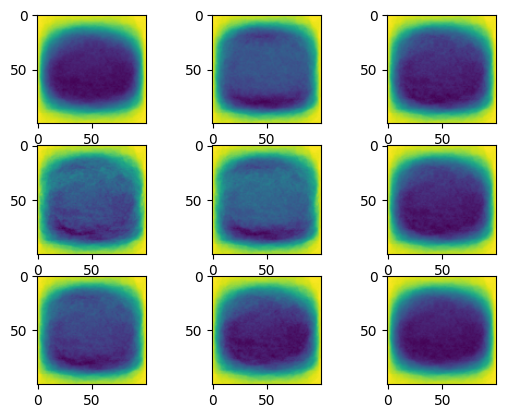

In [ ]:
plot_cluster_imgs(0)

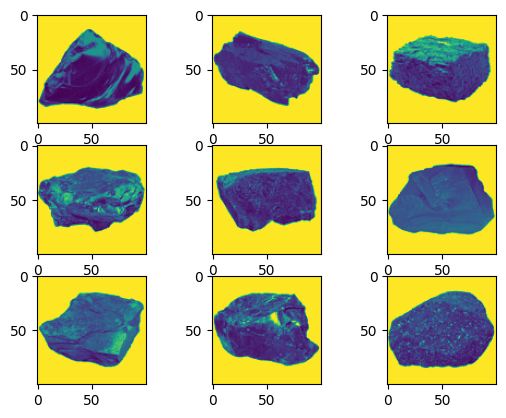

In [ ]:
plot_cluster_imgs_originals(1)

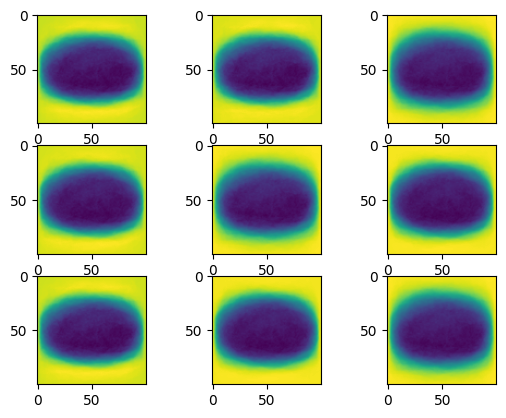

In [ ]:
plot_cluster_imgs(2)

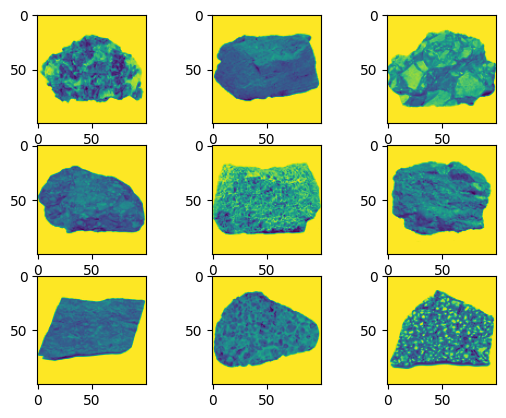

In [ ]:
plot_cluster_imgs_originals(2)

#6.Cluster the 360 images using EM.

A.Same as in the previous question, to speed up the algorithm, use PCA to reduce the dimensionality of the dataset to two. Determine the number of clusters using one of the techniques we discussed in class.

In [ ]:
from sklearn.mixture import GaussianMixture
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X_10k)
             for k in range(1, 17)]

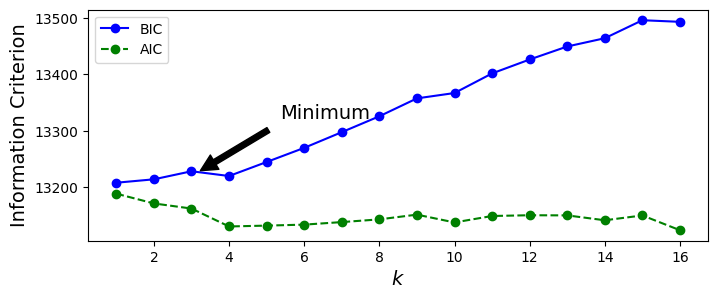

In [ ]:
bics = [model.bic(X_10k) for model in gms_per_k]
aics = [model.aic(X_10k) for model in gms_per_k]
plt.figure(figsize=(8, 3))
plt.plot(range(1, 17), bics, "bo-", label="BIC")
plt.plot(range(1, 17), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
#plt.axis([1, 18, np.min(aics) - 50, np.max(aics) + 50])
plt.annotate('Minimum',
             xy=(3, bics[3]),
             xytext=(0.35, 0.6),
             textcoords='figure fraction',
             fontsize=14,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.legend()
plt.show()

B.Visualize the clusters

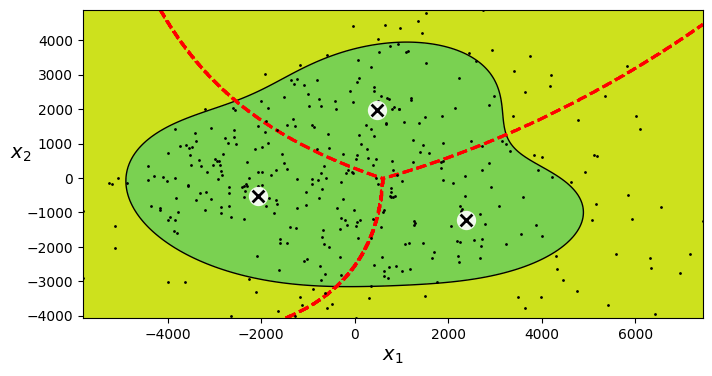

In [ ]:
from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    X=pd.DataFrame(X)
    plt.plot(X.iloc[:, 0], X.iloc[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gms_per_k[2], X_10k)

plt.show()


In [ ]:
ypred_gms=gms_per_k[11].predict(X_10k)
x2_gm=pd.DataFrame(X_10k)
x1_gm=pd.DataFrame(ypred_gms,columns=['cluster'])
X_10k_clus_gms=pd.concat([x2_gm,x1_gm],axis=1)

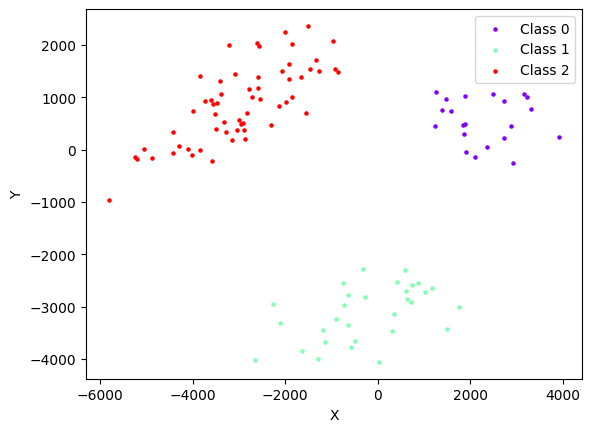

In [ ]:
num_classes=3
colors = plt.cm.rainbow(np.linspace(0, 1, num_classes))
fig, ax = plt.subplots()
for i in range(num_classes):
    mask = x1_gm['cluster'] == i
    ax.scatter(X_10k_clus_gms.loc[mask,'x'],X_10k_clus_gms.loc[mask,'y'],s=5, c=colors[i], label=f'Class {i}')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()
plt.show()

C.Use the model to generate 20 new rocks

In [ ]:
gm=GaussianMixture(n_components=3, n_init=10, random_state=42).fit(X_10k)
X_new, y_new = gm.sample(20)
X_gm=pd.concat([pd.DataFrame(X_new),pd.DataFrame(X_new)])
X_gm_recovered=pca_2D.inverse_transform(X_gm)

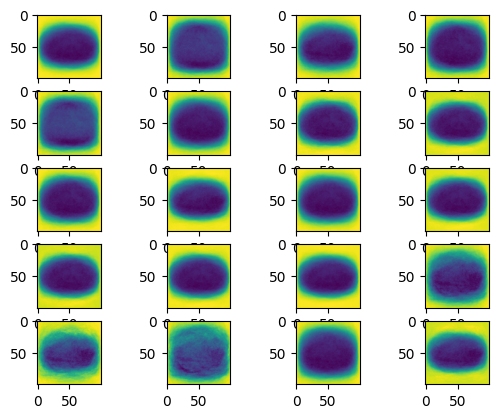

In [ ]:
f, axarr = plt.subplots(5,4)
idx=0
for i in range(5):
    for j in range(4):
        axarr[i,j].imshow(X_gm_recovered[idx].reshape((100,100)))
        idx+=1

7.Build a fully connected (dense) feedforward neural network with two hidden layers using Keras
(within Tensorflow) and train it on 50k Fashion MNIST training images. First hidden layer should
contain 200 neurons and second hidden layer should contain 50 neurons. The hidden layers should
have ReLU activation function. Train the network for 100 epochs. Plot training and validation loss
and accuracy as a function of training epochs. Try three different learning rates of your choice (make
the plots for each learning rate).

In [7]:
import os
import zipfile
import pandas as pd
from PIL import Image
import numpy as np

# Path to the zip file in Colab
zip_path = '/content/120 Rocks.zip'

# Extract the contents of the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/images')

# Function to resize images to 64x64, convert them to grayscale arrays, and create a DataFrame
def create_dataset(folder_path):
    data = []
    labels = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        if img_path.endswith(".jpg"):  # Assuming images are in JPG format
            img = Image.open(img_path)
            img = img.resize((100,100))  # Resize image to 64x64
            img = img.convert('L')  # Convert image to grayscale
            img_array = np.array(img)
            data.append(img_array)
            label = filename[0]  # Extract the first character of the filename as the label
            if label == 'I':
                labels.append(0)
            elif label == 'S':
                labels.append(1)
            elif label == 'M':
                labels.append(2)

    return np.array(data), np.array(labels)

# Path to the folder containing extracted images
image_folder_path = '/content/images/120 Rocks'

# Create the dataset
data, labels = create_dataset(image_folder_path)

# Create a DataFrame
df = pd.DataFrame(data.reshape((data.shape[0], -1)))  # Reshape data to a 1D array for each image
df['Label'] = labels

# Save the DataFrame to a CSV file
csv_path = '/content/120_dataset_resized_labelled.csv'
df.to_csv(csv_path, index=False)

# Display the first few rows of the DataFrame
df.head()

,0,1,2,3,4,5,6,7,8,9,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,Label
0,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,2
1,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,1
2,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,2
3,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,1
4,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,1


In [8]:
X_val=df.iloc[:,:-1].values
y_val=pd.DataFrame(df.iloc[:,-1])

In [52]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
X_train_normal=scaler.fit_transform(X_train)

In [54]:
X_val_normal=scaler.transform(X_val)

Epoch 1/50
12/12 [==============================] - 9s 255ms/step - loss: 3.2654 - accuracy: 0.3556 - val_loss: 3.4903 - val_accuracy: 0.3333
Epoch 2/50
12/12 [==============================] - 1s 120ms/step - loss: 3.0800 - accuracy: 0.3444 - val_loss: 2.7215 - val_accuracy: 0.3333
Epoch 3/50
12/12 [==============================] - 1s 103ms/step - loss: 2.8676 - accuracy: 0.3917 - val_loss: 2.5066 - val_accuracy: 0.3250
Epoch 4/50
12/12 [==============================] - 1s 106ms/step - loss: 3.0081 - accuracy: 0.3833 - val_loss: 2.7958 - val_accuracy: 0.3500
Epoch 5/50
12/12 [==============================] - 1s 98ms/step - loss: 2.8608 - accuracy: 0.3889 - val_loss: 2.7952 - val_accuracy: 0.3417
Epoch 6/50
12/12 [==============================] - 1s 98ms/step - loss: 2.7582 - accuracy: 0.4056 - val_loss: 2.5799 - val_accuracy: 0.3083
Epoch 7/50
12/12 [==============================] - 1s 97ms/step - loss: 2.6350 - accuracy: 0.4222 - val_loss: 2.4805 - val_accuracy: 0.3000
Epoch 8/5

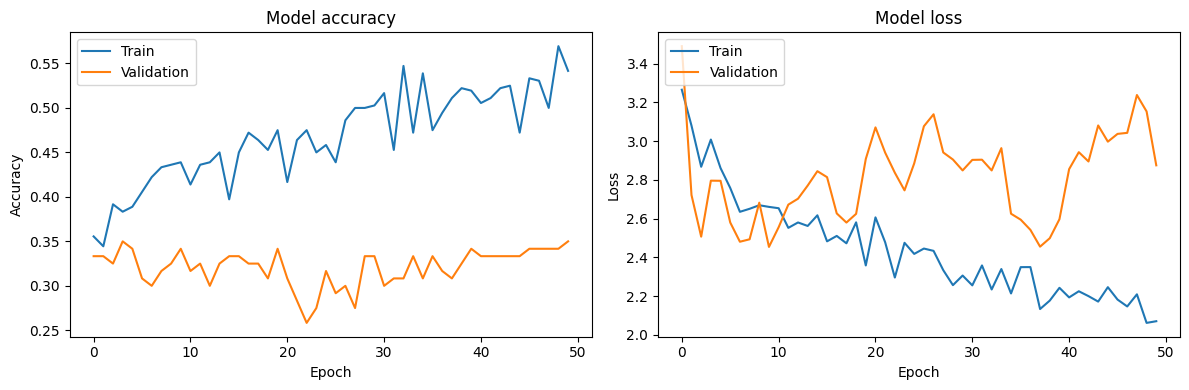

In [80]:
from tensorflow import keras
import time

from keras import regularizers

from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers

model_s = Sequential([
    InputLayer(input_shape=10000),
    Dense(512, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),  # Adding Dropout after the first Dense layer
    Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),  # Adding Dropout after the second Dense layer
    Dense(8, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),  # Adding Dropout after the third Dense layer
    Dense(3, activation="softmax")
])

lr = 0.0001  # Adjust the learning rate

model_s.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(lr), metrics=['accuracy'])

start_time = time.time()
history = model_s.fit(X_train_normal, y_train, epochs=50, validation_data=(X_val_normal, y_val))
end_time = time.time()

training_time = end_time - start_time
print(f"Total training time: {training_time} seconds")

# Plotting accuracy and loss
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


Epoch 1/50
4/4 [==============================] - 4s 380ms/step - loss: 7.7939 - accuracy: 0.3917 - val_loss: 5.6641 - val_accuracy: 0.3333
Epoch 2/50
4/4 [==============================] - 1s 117ms/step - loss: 6.0901 - accuracy: 0.3667 - val_loss: 5.0228 - val_accuracy: 0.3333
Epoch 3/50
4/4 [==============================] - 0s 110ms/step - loss: 4.2655 - accuracy: 0.3083 - val_loss: 3.5985 - val_accuracy: 0.3333
Epoch 4/50
4/4 [==============================] - 0s 115ms/step - loss: 3.6239 - accuracy: 0.2750 - val_loss: 2.8648 - val_accuracy: 0.3333
Epoch 5/50
4/4 [==============================] - 0s 123ms/step - loss: 3.0658 - accuracy: 0.3333 - val_loss: 2.4665 - val_accuracy: 0.4000
Epoch 6/50
4/4 [==============================] - 0s 109ms/step - loss: 2.9591 - accuracy: 0.3333 - val_loss: 2.1253 - val_accuracy: 0.4417
Epoch 7/50
4/4 [==============================] - 0s 116ms/step - loss: 2.1432 - accuracy: 0.4083 - val_loss: 2.5760 - val_accuracy: 0.3917
Epoch 8/50
4/4 [====

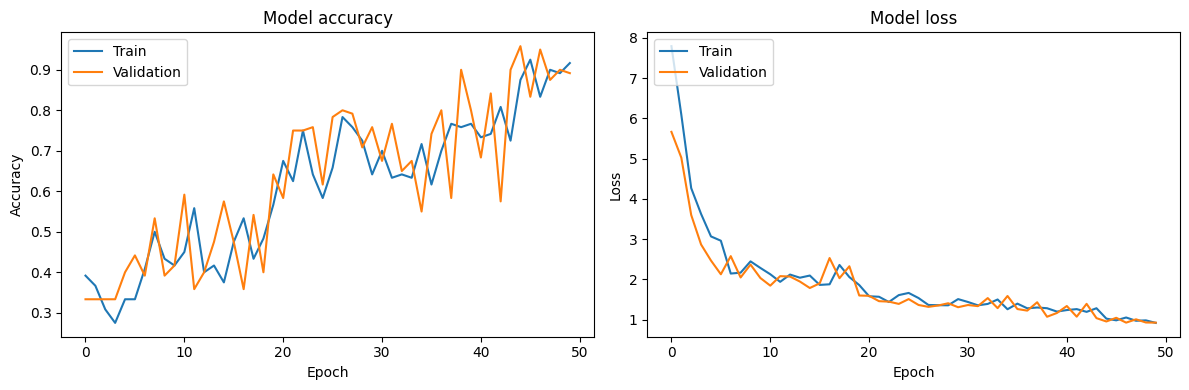

In [15]:
from tensorflow import keras
import time

from keras import regularizers

model_r = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=10000),
    keras.layers.Dense(512, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    keras.layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    keras.layers.Dense(8, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    keras.layers.Dense(3, activation="softmax")
])


lr = 0.001  # Adjust the learning rate

model_r.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(lr), metrics=['accuracy'])

start_time = time.time()
history = model_r.fit(X_train_normal, y_train, epochs=50, validation_data=(X_val_normal, y_val))
end_time = time.time()

training_time = end_time - start_time
print(f"Total training time: {training_time} seconds")

# Plotting accuracy and loss
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


Epoch 1/50
12/12 [==============================] - 2s 102ms/step - loss: 4.1039 - accuracy: 0.3417 - val_loss: 2.1899 - val_accuracy: 0.3333
Epoch 2/50
12/12 [==============================] - 1s 84ms/step - loss: 2.1359 - accuracy: 0.3333 - val_loss: 2.0759 - val_accuracy: 0.3333
Epoch 3/50
12/12 [==============================] - 1s 85ms/step - loss: 2.0388 - accuracy: 0.3333 - val_loss: 1.9911 - val_accuracy: 0.3333
Epoch 4/50
12/12 [==============================] - 1s 83ms/step - loss: 1.9580 - accuracy: 0.3333 - val_loss: 1.9161 - val_accuracy: 0.3333
Epoch 5/50
12/12 [==============================] - 1s 83ms/step - loss: 1.8885 - accuracy: 0.3333 - val_loss: 1.8542 - val_accuracy: 0.3333
Epoch 6/50
12/12 [==============================] - 1s 83ms/step - loss: 1.8316 - accuracy: 0.3333 - val_loss: 1.8032 - val_accuracy: 0.3333
Epoch 7/50
12/12 [==============================] - 1s 83ms/step - loss: 1.7843 - accuracy: 0.3333 - val_loss: 1.7603 - val_accuracy: 0.3333
Epoch 8/50
1

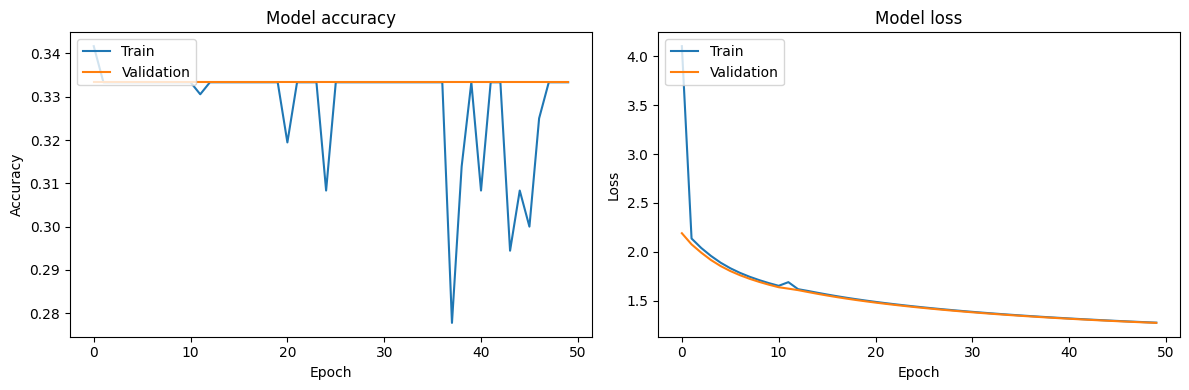

In [116]:
from tensorflow import keras
import time

from keras import regularizers

model_r = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=10000),
    keras.layers.Dense(512, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    keras.layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    keras.layers.Dense(8, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    keras.layers.Dense(3, activation="softmax")
])


lr = 0.001  # Adjust the learning rate

model_r.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(lr), metrics=['accuracy'])

start_time = time.time()
history = model_r.fit(X_train_normal, y_train, epochs=50, validation_data=(X_val_normal, y_val))
end_time = time.time()

training_time = end_time - start_time
print(f"Total training time: {training_time} seconds")

# Plotting accuracy and loss
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


C.How many parameters does the network have? How many of those parameters are bias parameters?

In [81]:
model_r.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 512)               5120512   
                                                                 
 batch_normalization_3 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_37 (Dense)            (None, 256)               131328    
                                                                 
 batch_normalization_4 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 256)              

Total Bias Parameters = 512 + 256 + 8 + 3 = 779 bias parameters

Therefore, the network has a total of 5,257,027 parameters, out of which 779 parameters are bias parameters.

7. D

In [82]:
from tensorflow.keras.models import Model
layer_name = model_s.layers[-2].name #Gets the second last layer of the model
intermediate_layer = Model(inputs=model_s.input, outputs=model_s.get_layer(layer_name).output)

In [83]:
train = intermediate_layer.predict(X_train)
val = intermediate_layer.predict(X_val)

4/4 [==============================] - 0s 13ms/step


In [85]:
from scipy.spatial import procrustes
mds_360 = np.loadtxt('/content/mds_360.txt')
mds_120 = np.loadtxt('/content/mds_120.txt')
mtx1_train, mtx2_train, train_disparity = procrustes(train, mds_360)
mtx1_val, mtx2_val, val_disparity = procrustes(val, mds_120)

In [114]:
correlation_df = pd.DataFrame(columns=['Data', 'Disparity','Dimension 1', 'Dimension 2', 'Dimension 3', 'Dimension 4', 'Dimension 5', 'Dimension 6', 'Dimension 7', 'Dimension 8'])
def calculate_correlation(mtx1, mtx2, data,disparity):

    correlation = np.corrcoef(mtx1, mtx2)

    return data,disparity,correlation

data,disparity,dimensions = calculate_correlation(mds_360,train, "Training",disparity_df['Disparity'][0])
correlation_df.loc[len(correlation_df.index)] = [data,disparity,dimensions[0,0],dimensions[0,1],dimensions[0,2],dimensions[0,3],dimensions[0,4],dimensions[0,5],dimensions[0,6],dimensions[0,7]]

data,disparity,dimensions = calculate_correlation(mds_120,val, "Validation",disparity_df['Disparity'][1])
correlation_df.loc[len(correlation_df.index)] = [data,disparity,dimensions[1,0],dimensions[1,1],dimensions[1,2],dimensions[1,3],dimensions[1,4],dimensions[1,5],dimensions[1,6],dimensions[1,7]]


In [115]:
correlation_df.head()

,Data,Disparity,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6,Dimension 7,Dimension 8
0,Training,0.987978,1.000000,0.428542,-0.070319,0.026586,0.045631,0.260818,-0.224954,0.199132
1,Validation,0.988185,0.324682,1.000000,0.734468,0.938082,-0.566556,-0.270435,-0.580648,-0.601115
